# Inventory Monitoring at Distribution Centers
### AWS Machine Learning Nanodegree – Capstone Project
**Author: Narmina Yadullayeva**

This notebook describes several steps of AWS MLE nanodegree capstone project.

Kernel to use: conda_pytorch_p39

In [23]:
# TODO: Install any packages that you might need
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 4.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 18.6 MB/s eta 0:00:00


In [18]:
# TODO: Import any packages that you might need
import pprint
import os
import json
import boto3
import tqdm
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd

import sagemaker

import torchvision
from torchvision import datasets, models, transforms

Outline:

- Data preparation. EDA
- Experimentation
- Deployment

## Download data

The cell below creates a folder called `train_data`, downloads data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [ ]:
def download_and_arrange_data():
    
    df_meta = []
    
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    meta_directory=os.path.join('metadata')
    if not os.path.exists(meta_directory):
        os.makedirs(meta_directory)
        
        
    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        for file_path in tqdm.tqdm(v):
            
            file_metadata = os.path.basename(file_path) 
            
            file_name=file_metadata.split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))
            
            #add metadata to dataframe   
            s3_client.download_file('aft-vbi-pds', os.path.join('metadata', file_metadata),
                                    os.path.join(meta_directory, file_metadata))

            f = open(os.path.join(meta_directory, file_metadata))
            data = json.load(f)
            data['filename']=file_name
            data['filepath']=os.path.join(directory, file_name)
            df_meta.append(data)
            
    df = pd.DataFrame(df_meta)
    df.to_csv("metadata/metadata.csv", index=False)
    
download_and_arrange_data()

## Dataset

Amazon Fulfillment Centers are bustling hubs of innovation that allow Amazon to deliver millions of products to over 100 countries worldwide with the help of robotic and computer vision technologies. The Amazon Bin Image Dataset contains images and metadata from bins of a pod in an operating Amazon Fulfillment Center. The bin images in this dataset are captured as robot units carry pods as part of normal Amazon Fulfillment Center operations. 

Amazon uses a random storage scheme where items are placed into accessible bins with available space, so the contents of each bin are random, rather than organized by specific product types. Thus, each bin image may show only one type of product or a diverse range of products. Occasionally, items are misplaced while being handled, so the contents of some bin images may not match the recorded inventory of that bin.

Amazon Fulfillment Technologies has made the bin images available free of charge on Amazon S3 to encourage recognition research in a variety of areas, including counting generic items and learning from weakly-tagged data. Over 500,000 bin JPEG images and corresponding JSON metadata files describing items in the bin are available in the aft-vbi-pds S3 bucket in the us-east-1 AWS Region.

Images are located in the bin-images directory, and metadata for each image is located in the metadata directory. Images and their associated metadata share simple numerical unique identifiers. For example, the metadata for the image at https://aft-vbi-pds.s3.amazonaws.com/bin-images/523.jpg is found at https://aft-vbi-pds.s3.amazonaws.com/metadata/523.json.

Let's take a look at metadata:

In [4]:
meta_df = pd.read_csv("metadata/metadata.csv")
meta_df

,BIN_FCSKU_DATA,EXPECTED_QUANTITY,filename,filepath,image_fname
0,"{'B00O0WRO08': {'asin': 'B00O0WRO08', 'height'...",1,100313.jpg,train_data/1/100313.jpg,NaN
1,"{'B00UO0UNOE': {'asin': 'B00UO0UNOE', 'height'...",1,09915.jpg,train_data/1/09915.jpg,NaN
2,"{'B003JKT3DS': {'asin': 'B003JKT3DS', 'height'...",1,103299.jpg,train_data/1/103299.jpg,NaN
3,"{'B00NG87OIY': {'asin': 'B00NG87OIY', 'height'...",1,00710.jpg,train_data/1/00710.jpg,NaN
4,"{'B00U2UZ40Y': {'asin': 'B00U2UZ40Y', 'height'...",1,05397.jpg,train_data/1/05397.jpg,NaN
...,...,...,...,...,...
10436,"{'0783811691': {'asin': '0783811691', 'height'...",5,100598.jpg,train_data/5/100598.jpg,NaN
10437,"{'0061782661': {'asin': '0061782661', 'height'...",5,1042.jpg,train_data/5/1042.jpg,1042.jpg
10438,"{'B0161TCR9A': {'asin': 'B0161TCR9A', 'height'...",5,07628.jpg,train_data/5/07628.jpg,NaN
10439,"{'B00DVQRJEK': {'asin': 'B00DVQRJEK', 'height'...",5,103667.jpg,train_data/5/103667.jpg,NaN


Checking for class imbalance:

In [5]:
meta_df['EXPECTED_QUANTITY'].value_counts().sort_values()

1    1228
5    1875
2    2299
4    2373
3    2666
Name: EXPECTED_QUANTITY, dtype: int64

Let's take a look at metadata frin sample image:

In [10]:
image_meta = eval(meta_df.sample()['BIN_FCSKU_DATA'].values[0])
print(image_meta)

{'0684848066': {'asin': '0684848066', 'height': {'unit': 'IN', 'value': 0.899999999082}, 'length': {'unit': 'IN', 'value': 8.399999991432}, 'name': 'In the Meantime: Finding Yourself and the Love You Want', 'normalizedName': 'In the Meantime: Finding Yourself and the Love You Want', 'quantity': 2, 'weight': {'unit': 'pounds', 'value': 0.8}, 'width': {'unit': 'IN', 'value': 5.399999994492}}, 'B01ENPNF6I': {'asin': 'B01ENPNF6I', 'height': {'unit': 'IN', 'value': 4.299999995614}, 'length': {'unit': 'IN', 'value': 10.299999989494001}, 'name': 'Sparco Bulldog Clip, 11/32-Inch Cap, Size 2, 2-1/4-Inch, 36 per Box, Silver (SPR58501) 3-PACK', 'normalizedName': 'Sparco Bulldog Clip, 11/32-Inch Cap, Size 2, 2-1/4-Inch, 36 per Box, Silver (SPR58501) 3-PACK', 'quantity': 1, 'weight': {'unit': 'pounds', 'value': 3.9999999966456374}, 'width': {'unit': 'IN', 'value': 5.099999994798}}}


Let's take a look at random image of the bin and its contents:

1ea One Size Fits All Book Cover
2ea Heavy Duty Retractable Dog Leash By Hertzko - Great for Small, Medium & Large Dogs up to 110lbs - Strong Nylon Ribbon Extends 16ft


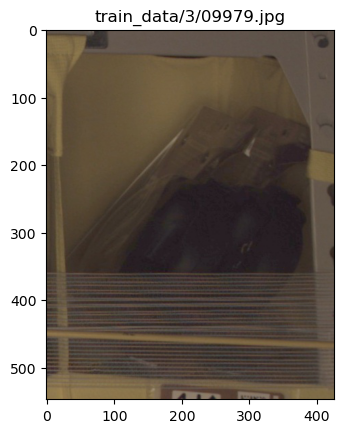

In [11]:
sample_image = meta_df.sample()
file_path, bin_class = sample_image[['filepath','EXPECTED_QUANTITY']].values[0]
image_meta = eval(sample_image['BIN_FCSKU_DATA'].values[0])
for obj in image_meta.keys():
    print(str(image_meta[obj]['quantity']) + 'ea ' + image_meta[obj]['name'])
    
img = mpimg.imread(file_path)
plt.imshow(img)
plt.title(str(file_path))
plt.show()

In [14]:
# loading dataset into tv dataset object
transform = transforms.Compose([    
        transforms.Resize(256),    
        transforms.CenterCrop(224),    
        transforms.ToTensor(),    
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

dataset = torchvision.datasets.ImageFolder(root='train_data/', transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 10442
    Root location: train_data/
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [16]:
# let's see what's distribution of targets 
from collections import Counter

counter_object = Counter(dataset.targets)
keys = counter_object.keys()
num_values = len(keys)

print(num_values)

5


In [ ]:
#TODO: Perform any data cleaning or data preprocessing

### Downloading dataset to S3 bucket

In [19]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [20]:
prefix = "capstone_project/data"
data_path = "train_data"

## this lines are commented out as I've downloaded this to s3 already
inputs = sagemaker_session.upload_data(path=data_path, bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-976414713425/capstone_project/data


In [8]:
## saved it here 
inputs = "s3://sagemaker-us-east-1-976414713425/capstone_project/data"

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

Trying training locally first

In [ ]:
!python train_model.py --data-path "train_data"

[2023-04-08 15:51:57.137 ip-172-16-142-30.ec2.internal:18873 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-08 15:51:57.175 ip-172-16-142-30.ec2.internal:18873 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
--- Running on Device cpu ---
--- Loading and Transforming Dataset ---
--- num_classes: 5 ---
--- Getting training and testing data loaders... ---
--- Initializing pre-trained model ---
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equ

In [ ]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values

In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [ ]:
#TODO: Create your hyperparameter search space

In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

In [ ]:
# TODO: Find the best hyperparameters

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [ ]:
# TODO: Deploy your model to an endpoint

In [ ]:
# TODO: Run an prediction on the endpoint

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances